In [199]:
import geopandas as gpd
import pandas as pd

In [200]:
leases = gpd.read_parquet("our_data/leases_with_nearest_quadrangles.parquet")
leases.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1767 entries, 0 to 124005
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   geometry            1767 non-null   geometry
 1   OBJECTID            1767 non-null   int64   
 2   landnum             1767 non-null   object  
 3   County              1767 non-null   object  
 4   parcel              1767 non-null   int64   
 5   fundtxt             1767 non-null   object  
 6   open_code           1767 non-null   int64   
 7   leased              1767 non-null   object  
 8   ke                  1767 non-null   object  
 9   lse_code            1767 non-null   int64   
 10  lse_seq             1767 non-null   int64   
 11  effdate             1766 non-null   object  
 12  expdate             1766 non-null   object  
 13  perpetual           0 non-null      object  
 14  aus                 1767 non-null   float64 
 15  rolodex_            1767 non-null

In [201]:
from shapely import wkt
wells = pd.read_csv("raw_data/cleaned_well_data.csv")
#do same filtering as in other notebook (wells pp_)
wells['geometry'] = gpd.points_from_xy(
    x=wells.SITE_LONGIT_DECIMAL, 
    y=wells.SITE_LATITUDE_DECIMAL, 
    crs="EPSG:4326"
    )
wells = gpd.GeoDataFrame(data=wells, geometry='geometry')
wells['date'] = pd.to_datetime(wells['date']) 
wells = wells[wells["date"]>="1/1/2000"]
wells = wells[wells["date"]<="1/1/2020"]
wells["utc_seconds"] = pd.to_datetime(wells['date'].astype("int64")).astype("int64")/ 10**9

C:\Users\liamw\AppData\Local\Temp\ipykernel_21916\626657163.py:2: DtypeWarning: Columns (36,45) have mixed types. Specify dtype option on import or set low_memory=False.
  wells = pd.read_csv("raw_data/cleaned_well_data.csv")


In [202]:
wells_on_lease = gpd.sjoin(left_df=leases, right_df=wells, how='left', predicate="contains")
leases_with_depth_trend = leases.merge(wells_on_lease, on="lease_", suffixes = ["", "_y"])
leases_with_depth_trend['date']

lease_
0        2019-02-07
0        2006-12-01
0        2019-02-05
0        2001-11-26
0        2001-11-27
            ...    
123642          NaT
123719          NaT
123815          NaT
123960          NaT
124005          NaT
Name: date, Length: 13694, dtype: datetime64[ns]

In [203]:
leases = leases.set_geometry("nearest_quadrangle").set_crs(crs=3857)
leases = leases.set_geometry("nearest_quadrangle").to_crs(crs=4326)
wells_on_nearest_quadrangle = gpd.sjoin(left_df=leases, right_df=wells, how='left', predicate="contains")
wells_on_nearest_quadrangle = wells_on_nearest_quadrangle.rename(columns ={'depth_20_year_trend':'nearby_depth_20_year_trend'})
wells_on_nearest_quadrangle.info()
leases_with_depth_trend = leases_with_depth_trend.merge(wells_on_nearest_quadrangle, on="lease_", suffixes=["", "_x"])

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 84859 entries, 0 to 124005
Columns: 108 entries, geometry to utc_seconds
dtypes: datetime64[ns](1), float64(36), geometry(3), int64(14), object(54)
memory usage: 70.6+ MB


In [204]:
wells_on_nearest_quadrangle.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 84859 entries, 0 to 124005
Columns: 108 entries, geometry to utc_seconds
dtypes: datetime64[ns](1), float64(36), geometry(3), int64(14), object(54)
memory usage: 70.6+ MB


In [205]:
wells_on_nearest_quadrangle['depth']

lease_
0           NaN
1         68.50
1         71.90
1         75.30
1         70.80
          ...  
124005    66.00
124005      NaN
124005    65.50
124005    73.90
124005    71.19
Name: depth, Length: 84859, dtype: float64

In [206]:
wells_on_lease['depth'].dropna()
wells_on_nearest_quadrangle['depth'].dropna()

lease_
1         68.50
1         71.90
1         75.30
1         70.80
1         66.60
          ...  
124005    71.30
124005    66.00
124005    65.50
124005    73.90
124005    71.19
Name: depth, Length: 74884, dtype: float64

In [207]:
import pandas as pd

# Calculate the first quartile (Q1) and third quartile (Q3) for 'depth' column
Q1 = wells_on_lease['depth'].quantile(0.25)
Q3 = wells_on_lease['depth'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Drop outliers
wells_on_lease_no_outliers = wells_on_lease[(wells_on_lease['depth'] >= lower_bound) & (wells_on_lease['depth'] <= upper_bound)]
wells_on_lease=wells_on_lease_no_outliers

In [208]:
wells_on_lease['depth']

lease_
0         226.3
0         221.7
0         120.7
0         120.9
0          39.1
          ...  
122697    225.8
122697    243.6
122697    364.8
122697    282.4
123013      5.0
Name: depth, Length: 11487, dtype: float64

In [209]:
wells_on_lease

,geometry,OBJECTID,landnum,County,parcel,fundtxt,open_code,leased,ke,lse_code,...,SITE_WSHD_CODE,SITE_LATLONG_DATUM_CODE,SITE_LATLONG_SOURCE_CODE,SITE_LATLONG_MEASURE_DATE,SITE_ALTITUDE_DATUM_CODE,SITE_ALT_SOURCE_CODE,SITE_ALT_MEASURE_DATE,SITE_LOCAL_ID_SOURCE_CODE,SITE_LOCAL_ID_MEASURE_DATE,utc_seconds
lease_,,,,,,,,,,,,,,,,,,,,,
0,"MULTIPOLYGON Z (((-114.75238 32.47979 0.00000,...",46266,1 8 2910 1 31002,Apache,1002,AGRICULTURE & MECHANICAL CLLGE,0,N,0,0,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.164931e+09
0,"MULTIPOLYGON Z (((-114.75238 32.47979 0.00000,...",46266,1 8 2910 1 31002,Apache,1002,AGRICULTURE & MECHANICAL CLLGE,0,N,0,0,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.006733e+09
0,"MULTIPOLYGON Z (((-114.75238 32.47979 0.00000,...",46266,1 8 2910 1 31002,Apache,1002,AGRICULTURE & MECHANICAL CLLGE,0,N,0,0,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.006819e+09
0,"MULTIPOLYGON Z (((-114.75238 32.47979 0.00000,...",46266,1 8 2910 1 31002,Apache,1002,AGRICULTURE & MECHANICAL CLLGE,0,N,0,0,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.164758e+09
0,"MULTIPOLYGON Z (((-114.75238 32.47979 0.00000,...",46266,1 8 2910 1 31002,Apache,1002,AGRICULTURE & MECHANICAL CLLGE,0,N,0,0,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.549411e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122697,"MULTIPOLYGON Z (((-112.46155 33.47909 0.00000,...",55573,2 2 234 7 241005,Maricopa,1005,PENITENTIARY LAND FUND,0,Y,3,0,...,6.0,D,ADWR,2023-01-13,A,ADWR,2020-08-31,ADWR,2023-01-13,1.039565e+09
122697,"MULTIPOLYGON Z (((-112.46155 33.47909 0.00000,...",55573,2 2 234 7 241005,Maricopa,1005,PENITENTIARY LAND FUND,0,Y,3,0,...,6.0,NaN,NaN,NaN,A,ADWR,2020-09-02,NaN,NaN,1.231805e+09
122697,"MULTIPOLYGON Z (((-112.46155 33.47909 0.00000,...",55573,2 2 234 7 241005,Maricopa,1005,PENITENTIARY LAND FUND,0,Y,3,0,...,6.0,NaN,NaN,NaN,A,ADWR,2020-09-02,NaN,NaN,1.231805e+09


In [210]:
wells2000L = wells_on_lease[wells_on_lease["date"]>="1/1/2000"]
wells2000L = wells_on_lease[wells_on_lease["date"]<="1/1/2001"]
wells2000L=wells2000L['depth'].mean()

wells2001L = wells_on_lease[wells_on_lease["date"]>="1/1/2001"]
wells2001L = wells_on_lease[wells_on_lease["date"]<="1/1/2002"]
wells2001L=wells2001L['depth'].mean()

wells2002L = wells_on_lease[wells_on_lease["date"]>="1/1/2002"]
wells2002L = wells_on_lease[wells_on_lease["date"]<="1/1/2003"]
wells2002L=wells2002L['depth'].mean()

wells2003L = wells_on_lease[wells_on_lease["date"]>="1/1/2003"]
wells2003L = wells_on_lease[wells_on_lease["date"]<="1/1/2004"]
wells2003L=wells2003L['depth'].mean()

wells2004L = wells_on_lease[wells_on_lease["date"]>="1/1/2004"]
wells2004L = wells_on_lease[wells_on_lease["date"]<="1/1/2005"]
wells2004L=wells2004L['depth'].mean()

wells2005L = wells_on_lease[wells_on_lease["date"]>="1/1/2005"]
wells2005L = wells_on_lease[wells_on_lease["date"]<="1/1/2006"]
wells2005L=wells2005L['depth'].mean()

wells2006L = wells_on_lease[wells_on_lease["date"]>="1/1/2006"]
wells2006L = wells_on_lease[wells_on_lease["date"]<="1/1/2007"]
wells2006L=wells2006L['depth'].mean()

wells2007L = wells_on_lease[wells_on_lease["date"]>="1/1/2007"]
wells2007L = wells_on_lease[wells_on_lease["date"]<="1/1/2008"]
wells2007L=wells2007L['depth'].mean()

wells2008L = wells_on_lease[wells_on_lease["date"]>="1/1/2008"]
wells2008L = wells_on_lease[wells_on_lease["date"]<="1/1/2009"]
wells2008L=wells2008L['depth'].mean()

wells2009L = wells_on_lease[wells_on_lease["date"]>="1/1/2009"]
wells2009L = wells_on_lease[wells_on_lease["date"]<="1/1/2010"]
wells2009L=wells2009L['depth'].mean()

wells2010L = wells_on_lease[wells_on_lease["date"]>="1/1/2010"]
wells2010L = wells_on_lease[wells_on_lease["date"]<="1/1/2011"]
wells2010L=wells2010L['depth'].mean()

wells2011L = wells_on_lease[wells_on_lease["date"]>="1/1/2011"]
wells2011L = wells_on_lease[wells_on_lease["date"]<="1/1/2012"]
wells2011L=wells2011L['depth'].mean()

wells2012L = wells_on_lease[wells_on_lease["date"]>="1/1/2012"]
wells2012L = wells_on_lease[wells_on_lease["date"]<="1/1/2013"]
wells2012L=wells2012L['depth'].mean()

wells2013L = wells_on_lease[wells_on_lease["date"]>="1/1/2013"]
wells2013L = wells_on_lease[wells_on_lease["date"]<="1/1/2014"]
wells2013L=wells2013L['depth'].mean()

wells2014L = wells_on_lease[wells_on_lease["date"]>="1/1/2014"]
wells2014L = wells_on_lease[wells_on_lease["date"]<="1/1/2015"]
wells2014L=wells2014L['depth'].mean()

wells2015L = wells_on_lease[wells_on_lease["date"]>="1/1/2015"]
wells2015L = wells_on_lease[wells_on_lease["date"]<="1/1/2016"]
wells2015L=wells2015L['depth'].mean()

wells2016L = wells_on_lease[wells_on_lease["date"]>="1/1/2016"]
wells2016L = wells_on_lease[wells_on_lease["date"]<="1/1/2017"]
wells2016L=wells2016L['depth'].mean()

wells2017L = wells_on_lease[wells_on_lease["date"]>="1/1/2017"]
wells2017L = wells_on_lease[wells_on_lease["date"]<="1/1/2018"]
wells2017L=wells2017L['depth'].mean()

wells2018L = wells_on_lease[wells_on_lease["date"]>="1/1/2018"]
wells2018L = wells_on_lease[wells_on_lease["date"]<="1/1/2019"]
wells2018L=wells2018L['depth'].mean()

wells2019L = wells_on_lease[wells_on_lease["date"]>="1/1/2019"]
wells2019L = wells_on_lease[wells_on_lease["date"]<="1/1/2020"]
wells2019L=wells2019L['depth'].mean()


In [214]:
wells2019L

158.78592669974753

In [215]:
wells2015L

232.22480481513327

In [217]:
wells2015L-wells2019L

73.43887811538573

In [211]:
wells2000Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2000"]
wells2000Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2001"]
wells2000Q = wells2000Q['depth'].mean()

wells2001Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2001"]
wells2001Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2002"]
wells2001Q = wells2001Q['depth'].mean()

wells2002Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2002"]
wells2002Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2003"]
wells2002Q = wells2002Q['depth'].mean()

wells2003Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2003"]
wells2003Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2004"]
wells2003Q = wells2003Q['depth'].mean()

wells2004Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2004"]
wells2004Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2005"]
wells2004Q = wells2004Q['depth'].mean()

wells2005Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2005"]
wells2005Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2006"]
wells2005Q = wells2005Q['depth'].mean()

wells2006Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2006"]
wells2006Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2007"]
wells2006Q = wells2006Q['depth'].mean()

wells2007Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2007"]
wells2007Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2008"]
wells2007Q = wells2007Q['depth'].mean()

wells2008Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2008"]
wells2008Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2009"]
wells2008Q = wells2008Q['depth'].mean()

wells2009Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2009"]
wells2009Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2010"]
wells2009Q = wells2009Q['depth'].mean()

wells2010Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2010"]
wells2010Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2011"]
wells2010Q = wells2010Q['depth'].mean()

wells2011Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2011"]
wells2011Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2012"]
wells2011Q = wells2011Q['depth'].mean()

wells2012Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2012"]
wells2012Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2013"]
wells2012Q = wells2012Q['depth'].mean()

wells2013Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2013"]
wells2013Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2014"]
wells2013Q = wells2013Q['depth'].mean()

wells2014Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2014"]
wells2014Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2015"]
wells2014Q = wells2014Q['depth'].mean()

wells2015Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2015"]
wells2015Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2016"]
wells2015Q = wells2015Q['depth'].mean()

wells2016Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2016"]
wells2016Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2017"]
wells2016Q = wells2016Q['depth'].mean()

wells2017Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2017"]
wells2017Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2018"]
wells2017Q = wells2017Q['depth'].mean()

wells2018Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2018"]
wells2018Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2019"]
wells2018Q = wells2018Q['depth'].mean()

wells2019Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] >= "1/1/2019"]
wells2019Q = wells_on_nearest_quadrangle[wells_on_nearest_quadrangle["date"] <= "1/1/2020"]
wells2019Q = wells2019Q['depth'].mean()


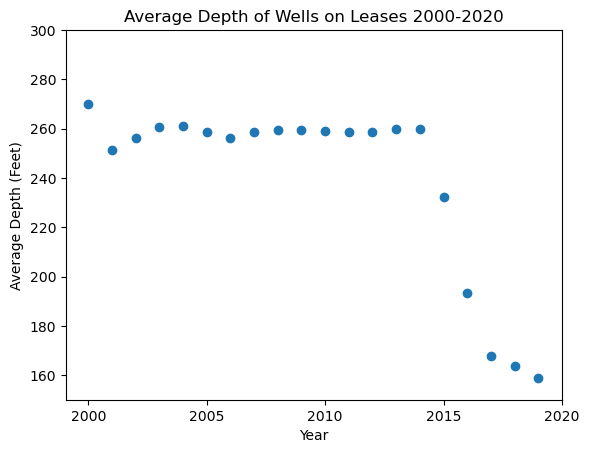

In [212]:
import matplotlib.pyplot as plt

# Create lists for years and mean depths
years = list(range(2000, 2020))
mean_depths = [wells2000L, wells2001L, wells2002L, wells2003L, wells2004L,
               wells2005L, wells2006L, wells2007L, wells2008L, wells2009L,
               wells2010L, wells2011L, wells2012L, wells2013L, wells2014L,
               wells2015L, wells2016L, wells2017L, wells2018L, wells2019L]

# Plot each year with its corresponding mean depth
plt.scatter(years, mean_depths)

# Set x-axis ticks to every 5 years
plt.xticks(range(2000, 2021, 5))

# Set y-axis limits
plt.ylim(150, 300)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Average Depth (Feet)')
plt.title('Average Depth of Wells on Leases 2000-2020')

# Display the plot
plt.show()


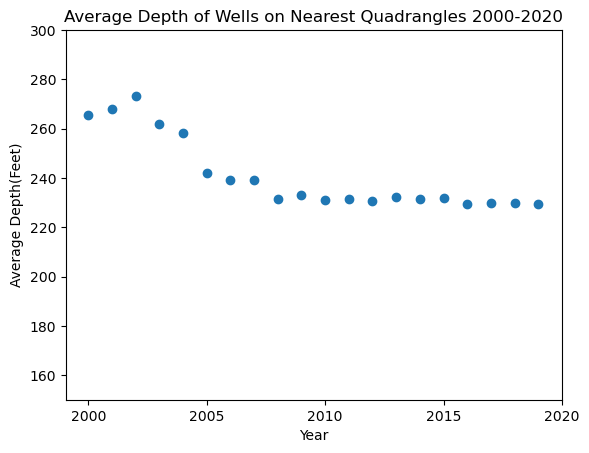

In [213]:
import matplotlib.pyplot as plt

# Mean depth values for each quarter
mean_depths = [wells2000Q, wells2001Q, wells2002Q, wells2003Q, wells2004Q,
               wells2005Q, wells2006Q, wells2007Q, wells2008Q, wells2009Q,
               wells2010Q, wells2011Q, wells2012Q, wells2013Q, wells2014Q,
               wells2015Q, wells2016Q, wells2017Q, wells2018Q, wells2019Q]

# Years for x-axis ticks
years = list(range(2000, 2020))

# Plot the scatter
plt.scatter(years, mean_depths)

# Set x-axis ticks to every 5 years
plt.xticks(range(2000, 2021, 5))

# Set y-axis limits
plt.ylim(150, 300)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Depth(Feet)')
plt.title('Average Depth of Wells on Nearest Quadrangles 2000-2020')

# Show plot
plt.show()
